In [169]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.special import jn_zeros

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [170]:
# Physical parameters
# ======= fixed ==========
L = 1e7 # horizontal length scale; appro radius of polar vortex
period = 9.925*3600  # period of Jupiter rotation
a = 6.99e7 

# ======= derived =========
omega = 2 * np.pi / period 
gamma = 2 * omega / a / a 
a_norm = a / L / 2.0   # dimensionless disk radius

# ======= defined/changed ==========
B1 = 5.18   # L**2/Ld1**2; can vary between 0.1 and 100
B1 = 51.8   # L**2/Ld1**2; can vary between 0.1 and 100
delta = 1.0 # H2/H1
B2 = delta**2 * B1 # L**2/Ld1**2;
U = 100
Gamma = gamma * (L**3) / U

In [171]:
Gamma - 2 * B1 

-102.88018234181692

In [172]:
def Jmk(m, a_norm, n=1):
    # m is azimuthal wavenumber
    # a_norm is the radius of the domain
    x_zeros = jn_zeros(m, n)
    km_n = x_zeros / a_norm
    return km_n

In [173]:
# calculate the radial wavenumber
nk = 15 # radial wavenumber range 
nm = 15 # azimuthal wavenumber range 
m = np.reshape(np.arange(1, nm+1), (nm, 1))
k = np.empty((nm, nk))
for i in m.flatten():
    k[i-1, :] = Jmk(i, a_norm, n=nk)

# total wavenumber square
l = (k**2) + (m**2)

In [174]:
# a1 * c2 + a2 * c + a3 = 0 to have a solution
a1 = l**2 + (delta**2 + 1) * l * B1
a2 = 2 * l * B1 * (1 - (delta**2)) + 2 * l * Gamma + B1 * (delta**2 + 1) * Gamma
a3 = l * B1 * (1 + (delta**2)) + Gamma * B1 * (1 - (delta**2)) - (l**2) + (Gamma**2)


In [175]:
# solve for wave speed and growth rate
c = np.empty(a1.shape + (2,), dtype=np.complex128)

# Loop through each element of the k array
for i in range(a1.shape[0]):
    for j in range(a1.shape[1]):
        
        # Compute roots and store
        c[i, j, :] = np.roots([a1[i,j], a2[i,j], a3[i,j]])

cr = np.real(c)  # shape (m, n, 2)
ci = np.imag(c)


In [176]:
ci_growth = ci[:,:,0] # positive; (nm, nk)

ci_colored = np.where(ci_growth > 1e-3, ci_growth * m, np.nan)  # shape: (nm, nk)
x = k.ravel()                    # k: shape (nm, nk), already gridded
y = m.repeat(k.shape[1], axis=1).ravel()  # m: (nm, 1) → repeat to match shape (nm, nk)
c = ci_colored.ravel()


In [177]:
# draw the boundary for the instability
instability = ((l**2) - 2 * (B1**2))**2 
thred = 4 * (B1)**4 - (Gamma)**2 * (B1**2)
plt_ins = instability.ravel()

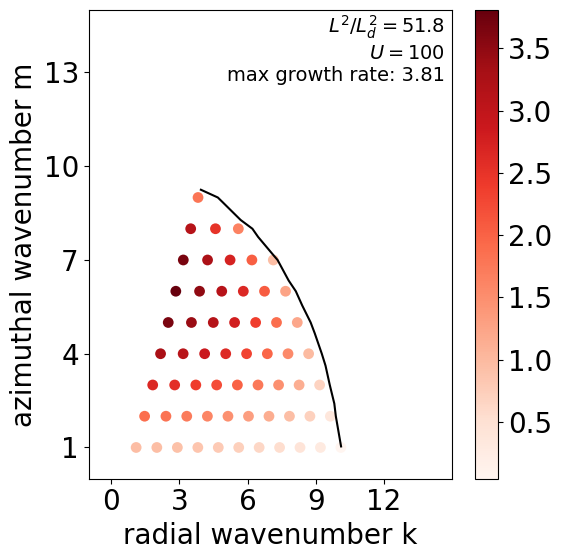

In [179]:
plt.rcParams['font.size'] = 20
# Plot
plt.figure(figsize=(6, 6))
sc = plt.scatter(x, y, c=c, cmap='Reds', edgecolors='none', s=60)
plt.colorbar(sc)
plt.contour(k, m.repeat(k.shape[1], axis=1), instability, levels=[thred], colors='black')
plt.xlabel('radial wavenumber k')
plt.ylabel('azimuthal wavenumber m')
# plt.title('m * ci')
plt.xlim([-1, nk])
plt.ylim([0, nm])
plt.xticks(np.arange(0, nk, 3))
plt.yticks(np.arange(1, nm, 3))
plt.text(
    0.98, 0.84,  # x, y in axes fraction (0–1)
    fr'$L^2/L_d^2 = {B1}$' + '\n' +
    fr'$U = {U}$' + '\n' +
    'max growth rate: '+fr'{np.nanmax(c):.3g}',
    ha='right', va='bottom',
    transform=plt.gca().transAxes,
    fontsize=14
)
plt.tight_layout()
plt.show()